## ***Jupyter Notebook to accompany the paper:***
    
# ***A data-driven framework for Paleomagnetic Euler Pole analysis***

### ***by L. C. Gallo$^1$*** *(l.c.gallo@geo.uio.no)* ***F. Sapienza$^2$ and M. Domeier$^1$***

*$^1$Centre for Earth Evolution and Dynamics, University of Oslo, Norway.*

*$^2$Department of Statistics, University of California Berkeley, United States.*

**VERSION 1.0 (11 November 2021)**

### Step 1 - Load the required packages

In [9]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as rotation
from scipy.optimize import minimize
import cartopy.crs as ccrs

from auxiliar.utils import GCD_cartesian

### Step 2 - Mathematical setup

Consider a set of three dimensional points $\{ (x_i, y_i, z_i) \}_{i=1}^N \subset \mathbb R^3$ contained in the three-dimensional sphere, that is, each one of the data points satisfy the equation $x_i^2 + y_i^2 + z_i^2 = 1$. We use the Cartesian coordinates $(x, y, z)$ and spherical coordinates $(\theta, \varphi)$ interchangeably, where both representations are connected via the set of equations

\begin{align}
    x &= \sin \theta \cos \varphi, \nonumber \\
    y &= \sin \theta \sin \varphi, \label{eq:spherical_coordinates}\\
    z &= \cos \theta. \nonumber
\end{align}

As follows:

In [10]:
def spherical2cartesian(v):
    """
    v[0] = theta - Latitude
    v[1] = phi - Longitude
    """
    
    x = np.cos(v[0]) * np.cos(v[1])  
    y = np.cos(v[0]) * np.sin(v[1])  
    z = np.sin(v[0])  
    
    return [x,y,z]

In [11]:
def cartesian2spherical(v):  
    """
    Takes an array of length 3 corresponding to a 3-dimensional vector and returns an array of length 2
    with latitude (inclination) and longitude (declination)
    """
    
    theta = np.arcsin(v[2]) 
    phi = math.atan2(v[1], v[0])
        
    return [theta, phi]

### Synthetic Example

We are going to consider a path described by a total of $N$ idealized (noiseless) paleomagnetic poles (PPs) organized in a single segment, inside this segment the orientation of the Euler Pole (EP) and the angular speed is constant. 

First, we define a function to populate the APWP segment.

In [12]:
def generate_APWP_segment_noiseless(PPs, ep, omega):
    """
    Generates a np.array of N_total paleomagnetic poles following the motion of a
    random governing EP (stable in time) 
    
    -- Parameters:
    PPs = number of PPs or time (Ma) - one pole each 1Ma
    ep = Cartesian coordinates [x,y,z] if the euler pole.
    omega = angular velocity (in radians per Ma)      
    """               
    
    pp = [0,0,-1] #the [i=0] first PP represents the south pole 
    PP = np.array(pp) 
    r = rotation.from_rotvec(omega * np.array(ep))    
    
    for i in range(PPs): 
        pp = r.apply(pp) # new pp without noise                
        PP = np.vstack((PP, np.array(pp)))                           
    
    return PP

We then proceed to the population of a synthetic segment

In [13]:
N = 30                   # number of Paleomagnetic Poles 
EPlat = -45              # coordinates of the Euler Pole
EPlong = 30              # coordinates of the Euler Pole
omega = np.radians(1.5)  # Euler Pole velocity

APWP = generate_APWP_segment_noiseless(N, spherical2cartesian([np.radians(EPlat), np.radians(EPlong)]), omega)

### Estimation of Paleomagnetic Euler Pole for a Single segment

First, we define the cost function that we will use to compute the goodness of fit of a single segment. This cost function is given by

$$ \sum_{i=k}^{m-1} \left ( \cos^{-1}(x_i x_q  + y_i y_q + z_i z_q) - \varphi  \right )^2 $$


In [14]:
PPs = APWP

def loss (v):
    
    theta = v[0]
    phi = v[1]
    varphi = v[2]
    
    res = 0
    pole = spherical2cartesian([theta, phi])
    
    for i in range(PPs.shape[0]):
        res += ( np.arccos( np.dot( PPs[i,:], pole)) - varphi ) ** 2        
    return res

We consider an optimization problem that seeks to minimize the cost function with respect to the three parameters of the circle that we write as the three-dimensional vector $\Theta = ( \phi_q, \theta_q, \varphi )$.

In contrast to the ordinary least square method, this optimization problem has no analytical solutions. However, we can use the method of gradient descent in order to find an optimal solution.  The gradient descent algorithm computes the gradient of the cost function and updates model parameters through $N_{iter}$ descent steps.

#### Solution

In [15]:
initialGuess = [np.random.uniform(-np.pi/2,np.pi/2),np.random.uniform(0,2*np.pi),np.random.uniform(-np.pi/2,np.pi/2)] # initial guess of the three-dimensional vector.

optimum = minimize(fun = loss, x0 = np.array(initialGuess), method='CG') # with contraints method= 'CG'

[theta, phi] = cartesian2spherical(spherical2cartesian([optimum.x[0],optimum.x[1]])) # ensures we stay within our stipulated constraints, and for visualization purposes

print(np.degrees(theta), np.degrees(phi))

-45.02038098808021 30.0117200657317


From the geographic coordinates of the inverted Euler pole $( \phi_q, \theta_q)$ we can infer a stage rotation angle $\Psi$ that brings the last pole to the first of the sequence as follows:

In [16]:
def StageEP(ep, PPs):
    ''' 
    Given an ep [cartesian] and a APWP [X] with a starting and ending pole, computes the neccesary rotation following 
    the law of cosines ($\cos{c} = \cos{a} \cos{b} + \sin{a} sin{b} cos{C}$)
    input: an EP [cartesian] and a starting and ending pole,
    output: angle [radians] to rotate the first point to the second by the given EP
    '''
    s = GCD_cartesian(PPs[0], PPs[-1]) # an angular distance between the first and last pole of a track
    p1 = GCD_cartesian(PPs[0], ep) #is a distance between the rotation pole and the first pole of a track 
    p2 = GCD_cartesian(PPs[-1], ep) #is an angular distance between the rotation pole and the last pole of a track. 
    
    w = np.arccos((np.cos(s) - np.cos(p1) * np.cos(p2)) / (np.sin(p1) * np.sin(p2)))
    
    r_positive = rotation.from_rotvec(w * np.array(ep)) 
    rotated_positive = r_positive.apply(PPs[0])
    
    r_negative = rotation.from_rotvec(-w * np.array(ep))
    rotated_negative = r_negative.apply(PPs[0])   
    
    if GCD_cartesian(rotated_positive, PPs[-1]) < GCD_cartesian(rotated_negative, PPs[-1]): #tests wheter or not the rotation has to be inverted.
        return w
    else:
        return -w

# Visualizing the results

In [17]:
APWP_spherical = np.array([cartesian2spherical(i) for i in APWP])

C:\Users\leandrog\Anaconda3\envs\PEPy\lib\site-packages\cartopy\mpl\geoaxes.py:1546: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  result = matplotlib.axes.Axes.scatter(self, *args, **kwargs)


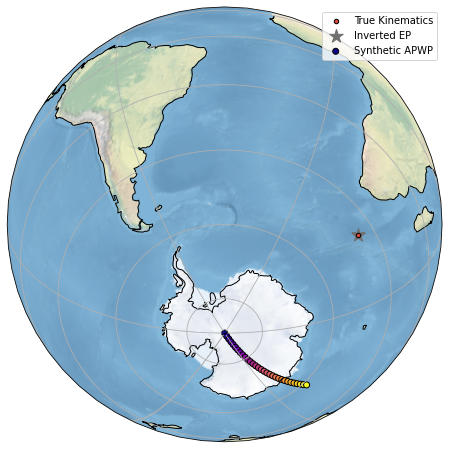

In [18]:
fig = plt.figure(figsize=(8,8))


#proj = ccrs.Mollweide()#Orthographic(45, 60)
proj = ccrs.Orthographic(-30, -60)

ax = plt.axes(projection=proj)    
ax.coastlines()
ax.stock_img()
ax.gridlines()

ax.scatter(x = np.degrees(APWP_spherical[:,1]), y = np.degrees(APWP_spherical[:,0]),
           c = np.array(range(len(APWP_spherical))), cmap="plasma", 
           Label = "Synthetic APWP", edgecolors='black',
           transform=ccrs.PlateCarree())

if theta > 0: # Calculates the backwards EP in order to visualize it on the SH
    theta = -theta
    if phi < 0 or phi > np.pi:
        phi = phi + np.pi
    else:
        phi = phi - np.pi

plt.scatter(x = np.degrees(phi), y = np.degrees(theta), color= "#707070", s = 200, marker = "*",
            Label = "Inverted EP",
            transform=ccrs.PlateCarree())

ax.scatter(EPlong, EPlat, color = "#DB4437", edgecolors='black',
           Label = "True Kinematics", s = 20,
           transform=ccrs.PlateCarree())

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels))
#ax.legend( loc = 'lower left')
plt.show()
#ax.figure.savefig('out.pdf')